In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|----------|-------------|
| Author(s)   | Lei Pan |
| Last updated | 10/27/2023 |

# Fine Tune Codey to Learn a New API

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, explaining code etc. Here is [the overview](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview) of all the Codey APIs.

In this notebook, we will show you how to fine tune Codey model, use fine-tuned Codey API to generate and modify functions, and use untuned model to explain code, generate unit tests, and refactor code by following the steps below.

- Step 1: Generate Vertex AI Search API code using untuned Codey model
- Step 2: Tune Codey model to Understand the latest Vertex AI Search API
- Step 3: Query tuned model to generate Vertex AI Search API code
- Step 4: Test the generated Vertex AI Search API code
- Step 5: Modify generated Code with Protobuf Parsing Code
- Step 6: Test the generated Vertex AI Search API code again
- Step 7: Use untuned Codey model to generate unit test
- Step 8: Use untuned Codey model to explain the code
- Step 9: Use untuned Codey model to refactor the Code
- Step 10: Use untuned Codey model to generate the Comments


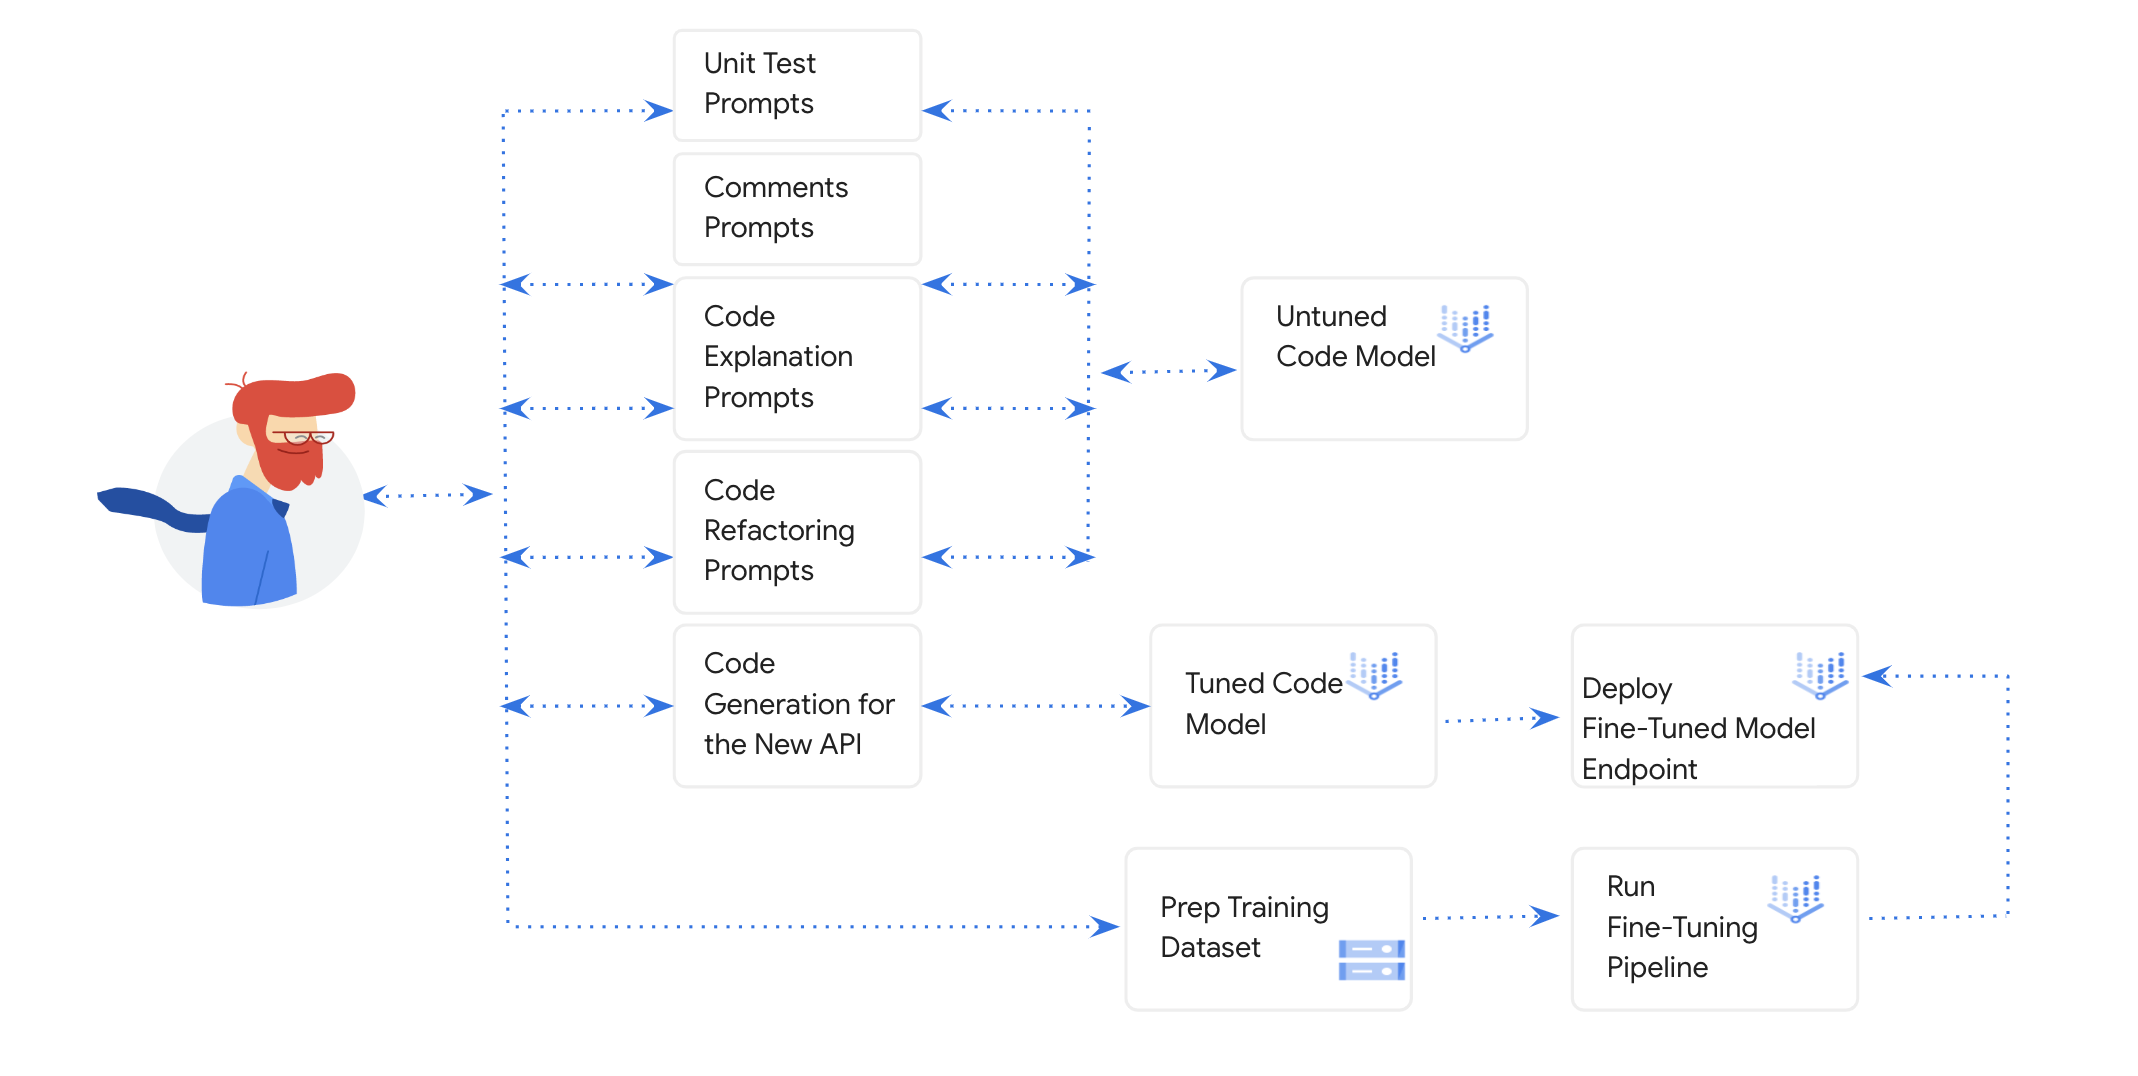

## Prep Work

If you don't have a GCP project set up and Vertex AI enabled, please follow [the doc](https://cloud.google.com/vertex-ai/docs/start/cloud-environment#set_up_a_project) to set them up before you proceed.



### Install Vertex AI SDK, Other Packages and Their Dependencies

Install the following packages required to execute this notebook.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    ! pip install google-cloud-discoveryengine
    ! pip install jsonlines
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

To use the newly installed packages in this runtime, you should restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ Before proceeding, please wait for the kernel to finish restarting ⚠️</b>
</div>

In [ ]:
import sys
import json
import os
import vertexai
from typing import Dict, List, Optional, Tuple
from google.cloud import discoveryengine
from google.protobuf.json_format import MessageToDict

### Initialize Vertex AI

Please set VERTEX_API_PROJECT and VERTEX_API_LOCATION below with your project id and location for Vertex AI. This should be the project in which you enabled Vertex AI.

In [ ]:
import vertexai
from vertexai.language_models import CodeGenerationModel

VERTEX_API_PROJECT = '<your project>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)

### Set Up Vertex AI Search Engine and Get Search Engine Id

- Step 1: Follow this [public doc](https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es#website) to add this URL (support.google.com/google-ads/*) to make a data store and index websites.
- Step 2: Once you create it, you should be able to see the search engine id on the data store page.
- Step 3: Copy that id and paste the id in the search_engine_id field in the next section.

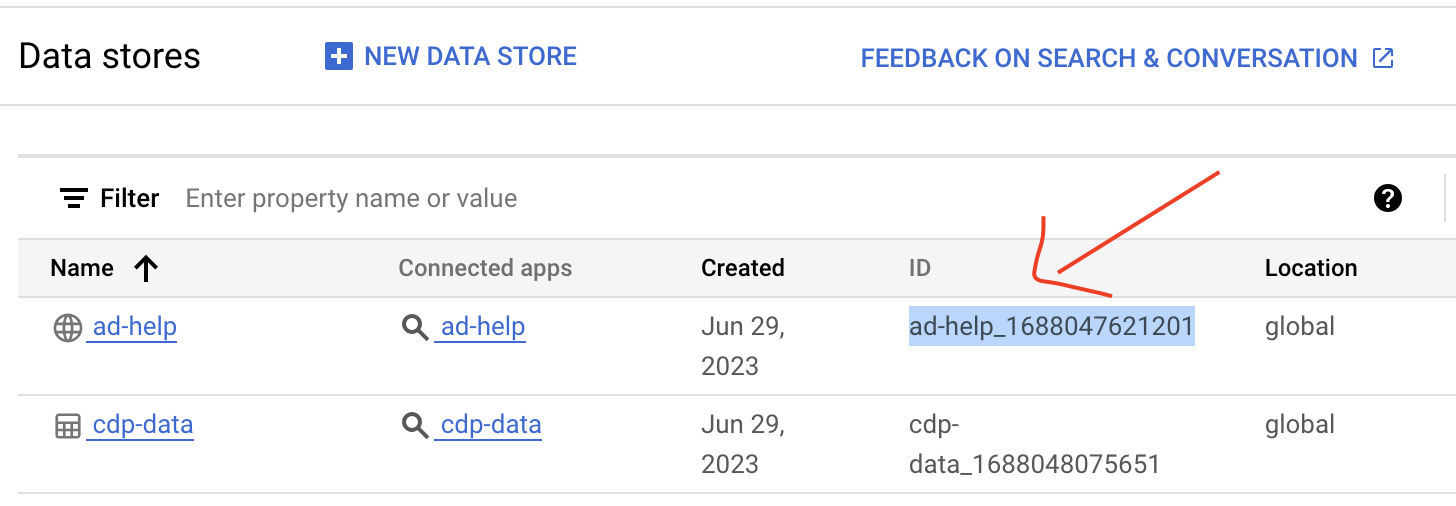


### Set Up Vertex AI Search API Parameters

Please set project_id, location, and search_engine_id for Vertex AI Search Data Store. This should be the project in which you set up Vertex AI Search Data Store.

In [ ]:
project_id = "<project id>"
location = "<location>"
search_engine_id = "<search engine id of the vertex AI search API>"
serving_config_id = "default_config"

### Initialize Code Generation Model

- You can specify the version of the Codey models you want to use. Here is [the list](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-versioning)  of all the available models


- You can pass 3 parameters here: prompt, max size of token, and temperature.

In [ ]:
code_generation_model = CodeGenerationModel.from_pretrained("code-bison@001")

def send_prompt(prefix, max_token=1024, model = code_generation_model):
    parameters = {
    "temperature": 0.2,
    "max_output_tokens": max_token
    }

    response = model.predict(
    prefix=prefix, **parameters
    )

    return response.text

## Step 1: Generate Vertex AI Search API Code using Untuned Codey Model

Let's use this prompt to test out untuned code generation model to see if it knows about how to generate code to use the latest Vertex AI Search API.

In [ ]:
prompt = """
Generate a function to send search queries to the Vertex AI Search API and retrieve the search results.
"""
print(send_prompt (prompt))

```python
def search_vertex_ai(query):

  # Create a client for the Vertex AI Search API.
  client = VertexAiSearchClient()

  # Create a search request.
  request = SearchRequest()
  request.query = query

  # Send the search request.
  response = client.search(request)

  # Get the search results.
  results = response.results

  # Return the search results.
  return results
```


As you can see in the result, it gave some generic API calls. This is not how Vertex AI Search API works. Let's tune the model and try again.

## Step 2: Tune Code Model to Understand the Latest Vertex AI Search API

- Step 1: You can choose the model that you want to tune.
- Step 2: Set up training_dataset_url with the URL pointing to your training dataset - a GCS bucket
- Step 3: Set up tuning_job_location and tuned_model_location to your desired locations.
- Step 4: Set up model_display_name with the name you want to display


If you don't have training dataset set up, you can run [this notebook](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/genai-on-vertex-ai/developer_productivity_with_genai/utilities/codey_fine_tuning_dataset_generation.ipynb) in the utilities folder to set it up.

In [ ]:
model = CodeGenerationModel.from_pretrained("code-bison@001")

training_dataset_url = "<dataset URL - gcs bucket>"
model.tune_model(
    training_data=training_dataset_url,
    train_steps=200,
    tuning_job_location="<job location>",
    tuned_model_location="<model location>",
    model_display_name="<display name>"
    )

You can check out fine-tuning job in Vertex AI Pipelines. You can follow [this link](https://cloud.google.com/vertex-ai/docs/pipelines/visualize-pipeline) to find the pipeline in your GCP project. Once your fine-tuning job finishes running. You can move to the next step.

## Step 3: Query Tuned Model to Generate Vertext AI Search API Code

It's quite straightforward to call the tuned model. Once you get the model name, you pass it to get_tuned_model method. We use list_models[0] because we only had this one model. If you have more than 1 model, please list out all the models and make sure you use the right one.

In [ ]:
list_models = CodeGenerationModel.from_pretrained("code-bison@001").list_tuned_model_names()
TUNED_MODEL_NAME = list_models[0]
tuned_model = CodeGenerationModel.get_tuned_model(TUNED_MODEL_NAME)
vertexai_search_code = send_prompt(prefix=prompt,model= tuned_model)
print(vertexai_search_code)

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)

    return response


This block of code looks much better. Let's test it out below.

## Step 4: Test the Generated Vertex AI Search API Code

In [ ]:
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)

    return response

In [ ]:
search_query = "how to improve campaign performance"
results = search_sample(project_id,location,search_engine_id,serving_config_id,search_query)
print(results)

As you can see the result above, the code it generated used the latest Vertex AI Search API correctly.

## Step 5: Modify the Generated Code with Protobuf Parsing Code

In the result above, the result is raw and contains everything. Let's ask the tuned model to modify it with protobuf parsing code so that we can have a nice formatted result.

In [ ]:
proto_prompt = """
Create a function to send search requests to Vertex AI Search API, convert the protobuf search response to a dictionary, and return the dictionary result.
"""
vertexai_search_code = send_prompt(prefix=proto_prompt,model= tuned_model)
print(vertexai_search_code)

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)
    results = [MessageToDict(result.document._pb) for result in response.results]

    return results


## Step 6: Test the Newly Generated Vertex AI Search API Code

Let's test the newly generated modified code.

In [ ]:
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)
    results = [MessageToDict(result.document._pb) for result in response.results]

    return results


search_query = "how to improve campaign performance"
results = search_sample(project_id,location,search_engine_id,serving_config_id,search_query)

for result in results:
  print(result['derivedStructData']['title'])
  print(result['derivedStructData']['link'])

About Performance Max campaigns - Google Ads Help
https://support.google.com/google-ads/answer/10724817?hl=en
Improve your Smart campaign's performance - Google Ads Help
https://support.google.com/google-ads/answer/7653465?hl=en
Upgrade your display campaigns to Performance Max campaigns ...
https://support.google.com/google-ads/answer/13451710?hl=en-GB
About conversion goals - Google Ads Help
https://support.google.com/google-ads/answer/10995103?hl=en
Optimization tips for Performance Max campaign for all business ...
https://support.google.com/google-ads/answer/11385582?hl=en
Boost your Search and Display results in Performance Max campaigns
https://support.google.com/google-ads/answer/13780156?hl=en
Reminder: Upgrade your Smart Shopping campaigns to ...
https://support.google.com/google-ads/answer/12368488?hl=en
About asset reporting in Performance Max - Google Ads Help
https://support.google.com/google-ads/answer/10725056?hl=en
5 ways to use Quality Score to improve your performanc

As you can see in the result above. It worked well.

## Step 7: Use Untuned Model to Generate Unit Test

You can absolutely use different models in the workflow. Now, we can switch to the untuned model to do the following tasks (from step 7 to step 10) since it's great at those tasks.

In [ ]:
unit_test_prompt = f"""
Generate unit test to cover this block of code {vertexai_search_code}
"""
print(send_prompt (prefix=unit_test_prompt))

```python
import unittest

from google.cloud import discoveryengine
from google.protobuf import json_format


class TestSearchSample(unittest.TestCase):

    def test_search_sample(self):
        project_id = "my-project"
        location = "us-central1"
        search_engine_id = "my-search-engine"
        serving_config_id = "my-serving-config"
        search_query = "hello world"

        results = search_sample(
            project_id=project_id,
            location=location,
            search_engine_id=search_engine_id,
            serving_config_id=serving_config_id,
            search_query=search_query,
        )

        self.assertIsNotNone(results)
        self.assertIsInstance(results, list)
        self.assertGreater(len(results), 0)

        for result in results:
            self.assertIsNotNone(result)
            self.assertIsInstance(result, discoveryengine.SearchResponse.SearchResult)
            self.assertIsNotNone(result.document)
            self.assertIsInstan

## Step 8: Use Untuned Model to Explain the Code

In [ ]:
explain_prompt = f"""
Explain this block of code {vertexai_search_code} line by line
"""
print(send_prompt (prefix=explain_prompt))

The function `search_sample` takes five arguments:

  * `project_id`: The ID of the project that the search engine belongs to.
  * `location`: The location of the search engine.
  * `search_engine_id`: The ID of the search engine.
  * `serving_config_id`: The ID of the serving configuration to use.
  * `search_query`: The search query to use.

The function first creates a client for the Discovery Engine API. It then uses
the client to create a `serving_config` object, which specifies the project,
location, search engine ID, and serving configuration ID.

The function then creates a `SearchRequest` object, which specifies the
`serving_config` and the search query. It then sends the request to the
Discovery Engine API and gets a `SearchResponse` object in return.

The function then iterates over the `results` field of the `SearchResponse`
object and converts each result to a dictionary. It then returns the list of
dictionaries.

Here is a more detailed explanation of each line of code:



## Step 9: Use Untuned Model to Refactor the Code

In [ ]:
refactor_prompt = f"""
Refactor this block of code {vertexai_search_code} by using descriptive and meaningful names and comments
"""
print(send_prompt(prefix=refactor_prompt))

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    """
    Searches for results in the given search engine.

    Args:
        project_id: The ID of the project that owns the search engine.
        location: The location of the search engine.
        search_engine_id: The ID of the search engine.
        serving_config_id: The ID of the serving config to use.
        search_query: The query to search for.

    Returns:
        A list of search results.
    """

    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = clie

## Step 10: Use Untuned Model to Generate Comments

In [ ]:
comment_prompt = f"""
Generate line-by-line comments for this block of code {vertexai_search_code}
"""
print(send_prompt (prefix=comment_prompt))

This function performs a search using the Discovery Engine API.

The function takes four arguments:

* `project_id`: The ID of the project that the search engine belongs to.
* `location`: The location of the search engine.
* `search_engine_id`: The ID of the search engine.
* `serving_config_id`: The ID of the serving configuration to use for the search.

The function returns a list of `SearchResult` objects, which contain information about the documents that were found in the search.

Here is a more detailed explanation of each line of code:

* `client = discoveryengine.SearchServiceClient()`: This creates a client object for the Discovery Engine API.
* `serving_config = client.serving_config_path(project=project_id, location=location, data_store=search_engine_id, serving_config=serving_config_id)`: This constructs the path to the serving configuration to use for the search.
* `request = discoveryengine.SearchRequest(serving_config=serving_config, query=search_query)`: This creates a `